# Elasticsearch

- Author: [liniar](https://github.com/namyoungkim)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/09-VectorStore/06-Elasticsearch.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/09-VectorStore/06-Elasticsearch.ipynb)


## Overview  
- This tutorial explores how to implement keyword, semantic, and multimodal search using `Elasticsearch` as a vector database, seamlessly integrated with `LangChain`.
- Elasticsearch offers powerful real-time search and analytics capabilities, while LangChain serves as a framework for integrating these capabilities into natural language processing and multimodal search applications.
- Through this tutorial, we will implement the following using Elasticsearch and LangChain:
    - 1️⃣ **Keyword Search**
    - 2️⃣ **Semantic Search**
    - 3️⃣ **Text-to-Image Multimodal Search**
    - 4️⃣ **Image-to-Image Multimodal Search**
    

### Table of Contents  

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Introduction to Elasticsearch](#introduction-to-elasticsearch)


### References
- [LangChain VectorStore Documentation](https://python.langchain.com/docs/how_to/vectorstores/)
- [LangChain Elasticsearch Integration](https://python.langchain.com/docs/integrations/vectorstores/elasticsearch/)
- [Elasticsearch Official Documentation](https://www.elastic.co/guide/en/elasticsearch/reference/index.html)  
- [Elasticsearch Vector Search Documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/dense-vector.html)
----

## Environment Setup  

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.  

**[Note]**  
- `langchain-opentutorial` is a package that provides a set of **easy-to-use environment setup,** **useful functions,** and **utilities for tutorials.**  
- You can check out the [`langchain-opentutorial` ](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.  

---

### 🛠️ **The following configurations will be set up**  

- **Jupyter Notebook Output Settings**
    - Display standard error ( `stderr` ) messages directly instead of capturing them.  
- **Install Required Packages** 
    - Ensure all necessary dependencies are installed.  
- **API Key Setup** 
    - Configure the API key for authentication.  
- **PyTorch Device Selection Setup** 
    - Automatically select the optimal computing device (CPU, CUDA, or MPS).
        - `{"device": "mps"}` : Perform embedding calculations using **MPS** instead of GPU. (For Mac users)
        - `{"device": "cuda"}` : Perform embedding calculations using **GPU.** (For Linux and Windows users, requires CUDA installation)
        - `{"device": "cpu"}` : Perform embedding calculations using **CPU.** (Available for all users)
- **Embedding Model Local Storage Path** 
    - Define a local path for storing embedding models.  

## Elasticsearch Setup
- In order to use the Elasticsearch vector search you must install the langchain-elasticsearch package.

### 🚀 Setting Up Elasticsearch with Elastic Cloud (Colab Compatible)
- Elastic Cloud allows you to manage Elasticsearch seamlessly in the cloud, eliminating the need for local installations.
- It integrates well with Google Colab, enabling efficient experimentation and prototyping.

---

### 📚 What is Elastic Cloud?  
- **Elastic Cloud** is a managed Elasticsearch service provided by Elastic.  
- Supports **custom cluster configurations** and **auto-scaling**.  
- Deployable on **AWS**, **GCP**, and **Azure**.  
- Compatible with **Google Colab**, allowing simplified cloud-based workflows.  

### 📌 Getting Started with Elastic Cloud  
1. **Sign up for Elastic Cloud’s Free Trial.**  
    - [Free Trial](https://cloud.elastic.co/registration?utm_source=langchain&utm_content=documentation)
2. **Create an Elasticsearch Cluster.**  
3. **Retrieve your Elasticsearch URL** and **Elasticsearch API Key** from the Elastic Cloud Console.  
    - Example ELASTICSEARCH_URL: `https://my-elasticsearch-project-abd...:123` 
---

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain-core",
        "langchain_huggingface",
        "langchain_elasticsearch",
        "elasticsearch",
        "python-dotenv",
        "uuid",
        "torch",
        "langchain_experimental",
        "open_clip_torch",
        "pillow",
        "pycocotools",
        "numpy",
        "matplotlib",
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Elasticsearch",
        "HUGGINGFACEHUB_API_TOKEN": "",
        "ES_URL": "",
        "ES_API_KEY": "",
    }
)

Environment variables have been set successfully.


You can alternatively set OPENAI_API_KEY in `.env` file and load it.

**[Note]** 
- This is not necessary if you've already set `OPENAI_API_KEY` in previous steps.

In [4]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
# Automatically select the appropriate device
import torch
import platform


def get_device():
    if platform.system() == "Darwin":  # macOS specific
        if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            print("✅ Using MPS (Metal Performance Shaders) on macOS")
            return "mps"
    if torch.cuda.is_available():
        print("✅ Using CUDA (NVIDIA GPU)")
        return "cuda"
    else:
        print("✅ Using CPU")
        return "cpu"


# Set the device
device = get_device()
print("🖥️ Current device in use:", device)

✅ Using MPS (Metal Performance Shaders) on macOS
🖥️ Current device in use: mps


In [6]:
# Embedding Model Local Storage Path
import os
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Set the download path to ./cache/
os.environ["HF_HOME"] = "./cache/"

## Introduction to Elasticsearch
- Elasticsearch is an open-source, distributed search and analytics engine designed to store, search, and analyze both structured and unstructured data in real-time.

### 📌 Key Features  
- **Real-Time Search:** Instantly searchable data upon ingestion  
- **Large-Scale Data Processing:** Efficient handling of vast datasets  
- **Scalability:** Flexible scaling through clustering and distributed architecture  
- **Versatile Search Support:** Keyword search, semantic search, and multimodal search  

### 📌 Use Cases  
- **Log Analytics:** Real-time monitoring of system and application logs  
- **Monitoring:** Server and network health tracking  
- **Product Recommendations:** Behavior-based recommendation systems  
- **Natural Language Processing (NLP):** Semantic text searches  
- **Multimodal Search:** Text-to-image and image-to-image searches  

### 🧠 Vector Database Functionality in Elasticsearch  
- Elasticsearch supports vector data storage and similarity search via **Dense Vector Fields.** As a vector database, it excels in applications like NLP, image search, and recommendation systems.

### 📌 Core Vector Database Features  
- **Dense Vector Field:** Store and query high-dimensional vectors  
- **KNN (k-Nearest Neighbors) Search:** Find vectors most similar to the input  
- **Semantic Search:** Perform meaning-based searches beyond keyword matching  
- **Multimodal Search:** Combine text and image data for advanced search capabilities  

### 📌 Vector Search Use Cases  
- **Semantic Search:** Understand user intent and deliver precise results  
- **Text-to-Image Search:** Retrieve relevant images from textual descriptions  
- **Image-to-Image Search:** Find visually similar images in a dataset  

### 🔗 Official Documentation Links  
- [Elasticsearch Official Documentation](https://www.elastic.co/guide/en/elasticsearch/reference/index.html)  
- [Elasticsearch Vector Search Documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/dense-vector.html)  

Elasticsearch goes beyond traditional text search engines, offering robust vector database capabilities essential for NLP and multimodal search applications. 🚀

In [7]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

model_name = "intfloat/multilingual-e5-large-instruct"

embeddings = HuggingFaceEndpointEmbeddings(
    model=model_name,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HUGGINGFACEHUB_API_TOKEN"],
)

In [8]:
%pip install -qU langchain-elasticsearch

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os

# Load environment variables
ES_URL = os.environ["ES_URL"]           # Elasticsearch host URL
ES_API_KEY = os.environ["ES_API_KEY"]   # Elasticsearch API key

# Ensure required environment variables are set
if not ES_URL or not ES_API_KEY:
    raise ValueError("Both ES_URL and ES_API_KEY must be set in environment variables.")

In [10]:
from elasticsearch import Elasticsearch

# Create Elasticsearch client
es = Elasticsearch(
    ES_URL,
    api_key=ES_API_KEY
)

# Check connection
if es.ping():
    print("✅ Successfully connected to Elastic Cloud!")
else:
    print("❌ Failed to connect to Elastic Cloud.")

✅ Successfully connected to Elastic Cloud!


In [11]:
# 🆕 Define a new index name  
index_name="es_langchain_tutorial"

# 🛠️ Define the mapping for the new index  
# This structure specifies the schema for documents stored in Elasticsearch
mapping = {
  "mappings": {
    "properties": {
      "metadata": {
        "properties": {
          "source": {
            "type": "text",
            "fields": {
              "keyword": {
                "type": "keyword",
                "ignore_above": 256
              }
            }
          }
        }
      },
      "text": {
        "type": "text",
        "fields": {
          "keyword": {
            "type": "keyword",
            "ignore_above": 256
          }
        }
      },
      "vector": {
        "type": "dense_vector",
        "dims": 1024,
        "index": True,
        "similarity": "cosine",
        "index_options": {
          "type": "int8_hnsw",
          "m": 16,
          "ef_construction": 100
        }
      }
    }
  }
}

# 🚀 Create a new index with the defined mapping  
# Check if the index exists and create it if not
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=mapping)
    print(f"✅ Index '{index_name}' created successfully.")
else:
    print(f"⚠️ Index '{index_name}' already exists. Skipping creation.")

✅ Index 'es_langchain_tutorial' created successfully.


In [12]:
from langchain_elasticsearch import ElasticsearchStore

# Initialize ElasticsearchStore
vector_store = ElasticsearchStore(
    index_name=index_name,              # Elasticsearch index name
    embedding=embeddings,               # Object responsible for text embeddings
    es_url=ES_URL,                      # Elasticsearch host URL
    es_api_key=ES_API_KEY,              # Elasticsearch API key for authentication
)

## Manage vector store
- Add items to vector store

In [13]:
from uuid import uuid4

from langchain_core.documents import Document

document_1 = Document(
    page_content="I had chocalate chip pancakes and scrambled eggs for breakfast this morning.",
    metadata={"source": "tweet"},
)

document_2 = Document(
    page_content="The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news"},
)

document_3 = Document(
    page_content="Building an exciting new project with LangChain - come check it out!",
    metadata={"source": "tweet"},
)

document_4 = Document(
    page_content="Robbers broke into the city bank and stole $1 million in cash.",
    metadata={"source": "news"},
)

document_5 = Document(
    page_content="Wow! That was an amazing movie. I can't wait to see it again.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Is the new iPhone worth the price? Read this review to find out.",
    metadata={"source": "website"},
)

document_7 = Document(
    page_content="The top 10 soccer players in the world right now.",
    metadata={"source": "website"},
)

document_8 = Document(
    page_content="LangGraph is the best framework for building stateful, agentic applications!",
    metadata={"source": "tweet"},
)

document_9 = Document(
    page_content="The stock market is down 500 points today due to fears of a recession.",
    metadata={"source": "news"},
)

document_10 = Document(
    page_content="I have a bad feeling I am going to get deleted :(",
    metadata={"source": "tweet"},
)

documents = [
    document_1,
    document_2,
    document_3,
    document_4,
    document_5,
    document_6,
    document_7,
    document_8,
    document_9,
    document_10,
]
uuids = [str(uuid4()) for _ in range(len(documents))]

In [14]:
uuids

['cb6fe463-9348-4796-b60d-b62a03988e2e',
 'c7958f32-1274-43b2-ac8b-5d27cc14ae03',
 '63d56cdd-10fc-4eb8-9aaf-2f0bbd6f3ba8',
 '8a68fedb-8ec4-492a-8225-4cd74534d613',
 'de26f0bf-a2d2-49c5-a110-35fa8feec369',
 '88dbc106-c8b0-42dc-aaee-26a73d0d6652',
 'a353a8c6-1e0e-4da5-bb8b-47326476bbd5',
 'b238e673-0647-40cf-bce3-fc949825ce90',
 'e6424b50-34f7-479c-b46b-8d3b9ca882af',
 'bb1a0c80-6bf8-4164-bf0c-a7f99477b97d']

In [15]:
vector_store.add_documents(documents=documents, ids=uuids)
print("✅ Documents added successfully!")

✅ Documents added successfully!


## Keyword Search

In [16]:
# keyword search query
keyword="iPhone"

query = {
    "query": {
        "match": {
            "text": keyword
        }
    }
}

# Execute Elasticsearch search
results = es.search(index=index_name, body=query)
print("🔍 Keyword: ", keyword)
print("✅ Keyword Search Results:")
for hit in results['hits']['hits']:
    print(f"- {hit['_source']['text']} (Source: {hit['_source']['metadata']['source']})")

🔍 Keyword:  iPhone
✅ Keyword Search Results:
- Is the new iPhone worth the price? Read this review to find out. (Source: website)


### 🔑 Explanation  
- The **match query** is used to **search for documents** containing the keyword `"iPhone"` .  
- The results will be returned with the following fields:  
    - **text:** The content of the document.  
    - **metadata:** Additional information or context related to the document.  

This approach ensures that **documents containing the specified keyword** are **efficiently retrieved** along with their **relevant metadata**. 🚀

## Semantic Search
- Similarity search
    - Performing a simple similarity search with filtering on metadata can be done as follows:

In [17]:
# Execute Semantic Search
search_query = "What's the weather like tomorrow?"
results = vector_store.similarity_search(search_query, k=3)

print("🔍 Question: ", search_query)
print("🤖 Semantic Search Results:")
for result in results:
    print(f"- {result.page_content} (Source: {result.metadata['source']})")

🔍 Question:  What's the weather like tomorrow?
🤖 Semantic Search Results:
- The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees. (Source: news)
- I have a bad feeling I am going to get deleted :( (Source: tweet)
- Wow! That was an amazing movie. I can't wait to see it again. (Source: tweet)


In [18]:
# Execute Semantic Search
search_query = "LangChain provides abstractions to make working with LLMs easy"
results = vector_store.similarity_search(search_query, k=3)

print("🔍 Question: ", search_query)
print("🤖 Semantic Search Results:")
for result in results:
    print(f"- {result.page_content} (Source: {result.metadata['source']})")

🔍 Question:  LangChain provides abstractions to make working with LLMs easy
🤖 Semantic Search Results:
- LangGraph is the best framework for building stateful, agentic applications! (Source: tweet)
- Building an exciting new project with LangChain - come check it out! (Source: tweet)
- I have a bad feeling I am going to get deleted :( (Source: tweet)


In [19]:
# Execute hybrid search
search_query = "LangChain provides abstractions to make working with LLMs easy"
keyword = "tweet"

results = vector_store.similarity_search(
    query=search_query,
    k=2,
    filter=[{"term": {"metadata.source.keyword": keyword}}],
)

print("🔍 search_query: ", search_query)
print("🔍 keyword: ", keyword)

for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

🔍 search_query:  LangChain provides abstractions to make working with LLMs easy
🔍 keyword:  tweet
* LangGraph is the best framework for building stateful, agentic applications! [{'source': 'tweet'}]
* Building an exciting new project with LangChain - come check it out! [{'source': 'tweet'}]


Similarity search with score
- If you want to execute a similarity search and receive the corresponding scores you can run:

In [20]:
# hybrid search with score
search_query = "Will it be hot tomorrow"
keyword = "news"


results = vector_store.similarity_search_with_score(
    query=search_query,
    k=1,
    filter=[{"term": {"metadata.source.keyword": keyword}}],
)

print("🔍 search_query: ", search_query)
print("🔍 keyword: ", keyword)

for doc, score in results:
    print(f"* [SIM={score:3f}] {doc.page_content} [{doc.metadata}]")

🔍 search_query:  Will it be hot tomorrow
🔍 keyword:  news
* [SIM=0.903740] The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees. [{'source': 'news'}]


## Query by turning into retriever
- You can also transform the vector store into a retriever for easier usage in your chains.

In [21]:
search_query = "Stealing from the bank is a crime"
print("🔍 search_query: ", search_query)

retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.2}
)

retriever.invoke(search_query)

🔍 search_query:  Stealing from the bank is a crime


[Document(metadata={'source': 'news'}, page_content='Robbers broke into the city bank and stole $1 million in cash.'),
 Document(metadata={'source': 'tweet'}, page_content='I have a bad feeling I am going to get deleted :('),
 Document(metadata={'source': 'news'}, page_content='The stock market is down 500 points today due to fears of a recession.'),
 Document(metadata={'source': 'tweet'}, page_content='Building an exciting new project with LangChain - come check it out!')]

### Delete documents

In [22]:
# Delete a Document by Specific UUID
vector_store.delete(ids=[uuids[-1]])

True

In [23]:
# Define a query to match all documents
query = {
    "query": {
        "match_all": {}
    }
}

# Execute the delete operation
response = es.delete_by_query(index=index_name, body=query)
print("🗑️ All documents have been successfully deleted!")
print(response)

🗑️ All documents have been successfully deleted!
{'took': 252, 'timed_out': False, 'total': 9, 'deleted': 9, 'batches': 1, 'version_conflicts': 0, 'noops': 0, 'retries': {'bulk': 0, 'search': 0}, 'throttled_millis': 0, 'requests_per_second': -1.0, 'throttled_until_millis': 0, 'failures': []}


In [24]:
%pip install langchain_experimental pillow pycocotools open_clip_torch matplotlib

Note: you may need to restart the kernel to use updated packages.


### Note
- Let’s now create an index specifically designed for multimodal search. 🚀✨

In [25]:
# 🆕 Define a new index name  
new_index_name = "es_langchain_tutorial_multimodal"

# 🛠️ Define the mapping for the new index  
# This structure specifies the schema for documents stored in Elasticsearch
mapping = {
    "mappings": {
        "properties": {
            "text": {  # Field for storing textual content
                "type": "text"
            },
            "metadata": {  # Field for storing metadata information
                "properties": {
                    "image_path": {  # Sub-field for image path metadata
                        "type": "keyword"
                    }
                }
            },
            "vector": {  # Field for storing vector embeddings
                "type": "dense_vector",  # Specifies dense vector type
                "dims": 1024,  # Number of dimensions in the vector
                "index": True,  # Enable indexing for vector search
                "similarity": "cosine"  # Use cosine similarity for vector comparisons
            }
        }
    }
}

# 🚀 Create a new index with the defined mapping  
# Check if the index exists and create it if not
if not es.indices.exists(index=new_index_name):
    es.indices.create(index=new_index_name, body=mapping)
    print(f"✅ Index '{new_index_name}' created successfully.")
else:
    print(f"⚠️ Index '{new_index_name}' already exists. Skipping creation.")

✅ Index 'es_langchain_tutorial_multimodal' created successfully.


In [26]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image
import os

MODEL = "ViT-H-14-quickgelu"
CHECKPOINT = "dfn5b"

clip_embeddings = OpenCLIPEmbeddings(model_name=MODEL, checkpoint=CHECKPOINT)

open_clip_pytorch_model.bin:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [27]:
from langchain_elasticsearch import ElasticsearchStore

# Initialize ElasticsearchStore
vector_store = ElasticsearchStore(
    index_name=new_index_name,                      # Elasticsearch index name
    embedding=clip_embeddings,                      # Object responsible for text embeddings
    es_url=ES_URL,                                  # Elasticsearch host URL
    es_api_key=ES_API_KEY,                          # Elasticsearch API key for authentication
)

print("✅ Elasticsearch and OpenCLIP model configured successfully.")

✅ Elasticsearch and OpenCLIP model configured successfully.


## Downloading the COCO Dataset (Subset)
- The **COCO Dataset** is a widely-used multimodal dataset that includes **images paired with textual descriptions (captions).**
- In this step, we’ll **download a subset of the dataset** using the official API and **store it in the `./data` folder.** 

---

### ✅ Folder Creation & Dataset Download  

### 🔑 Explanation:  
- We’ll **download both the COCO image dataset and the caption dataset.** 
- The datasets will be **saved in the `./data` folder`** and **automatically extracted for use.** 

This setup ensures that the **datasets are organized and ready for further processing. 🚀✨**  


In [28]:
import os
import requests
import zipfile

# Define the directory for storing datasets
DATA_DIR = "./data"
COCO_API_URL = "http://images.cocodataset.org/zips/val2017.zip"
CAPTIONS_API_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Create the dataset directory if it doesn't already exist
os.makedirs(DATA_DIR, exist_ok=True)

# Function to check if a file already exists
def file_exists(file_path):
    return os.path.exists(file_path)

# Function to download a file from a given URL
def download_file(url, save_path):
    print(f"📥 Downloading {url} ...")
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"✅ Saved to {save_path}")

# Function to unzip downloaded files into a target directory
def unzip_file(zip_path, extract_to):
    print(f"📦 Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted to {extract_to}")


# Download and extract COCO image dataset if not already done
image_zip_path = os.path.join(DATA_DIR, "val2017.zip")
image_folder_path = os.path.join(DATA_DIR, "val2017")

if not file_exists(image_folder_path):
    if not file_exists(image_zip_path):
        download_file(COCO_API_URL, image_zip_path)
    unzip_file(image_zip_path, DATA_DIR)
else:
    print(f"🚫 Image dataset already exists at {image_folder_path}, skipping download and extraction.")


# Download and extract COCO captions dataset if not already done
captions_zip_path = os.path.join(DATA_DIR, "annotations_trainval2017.zip")
captions_folder_path = os.path.join(DATA_DIR, "annotations")

if not file_exists(captions_folder_path):
    if not file_exists(captions_zip_path):
        download_file(CAPTIONS_API_URL, captions_zip_path)
    unzip_file(captions_zip_path, DATA_DIR)
else:
    print(f"🚫 Captions dataset already exists at {captions_folder_path}, skipping download and extraction.")

📥 Downloading http://images.cocodataset.org/zips/val2017.zip ...
✅ Saved to ./data/val2017.zip
📦 Extracting ./data/val2017.zip ...
✅ Extracted to ./data
📥 Downloading http://images.cocodataset.org/annotations/annotations_trainval2017.zip ...
✅ Saved to ./data/annotations_trainval2017.zip
📦 Extracting ./data/annotations_trainval2017.zip ...
✅ Extracted to ./data


### 🚀 Indexing the COCO Dataset into Elasticsearch Using a Separate Storage Approach  
🛠️ 3. Data Indexing  

✅ 3.1 Data Preparation  

The COCO dataset is used as an example.

In [29]:
from pycocotools.coco import COCO

# Dataset setup
DATA_DIR = "./data"
ANNOTATIONS_FILE = os.path.join(DATA_DIR, "annotations", "captions_val2017.json")
IMAGES_DIR = os.path.join(DATA_DIR, "val2017")

# Load the COCO caption dataset
coco = COCO(ANNOTATIONS_FILE)

documents = []

# Use the first 100 images and captions
for img_id in coco.getImgIds()[:100]:
    img_info = coco.loadImgs(img_id)[0]
    caption_ids = coco.getAnnIds(imgIds=img_id)
    captions = [coco.loadAnns(c_id)[0]['caption'] for c_id in caption_ids]
    
    img_path = os.path.join(IMAGES_DIR, img_info['file_name'])
    
    for caption in captions:
        documents.append({
            "text": caption,
            "metadata": {"image_path": img_path}
        })
    
    documents.append({
        "text": "Image embedding",
        "metadata": {"image_path": img_path}
    })

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


✅ 3.2 Storing Text and Image Embeddings

## Text-to-Image Multimodal Search
- Returns the most relevant image based on the input text description.
- This approach leverages vector embeddings to compare textual input with image metadata, enabling semantic similarity matching.

This method is ideal for scenarios where users search for images using natural language descriptions. 🚀✨

🔍 Text-to-Image Search Results:


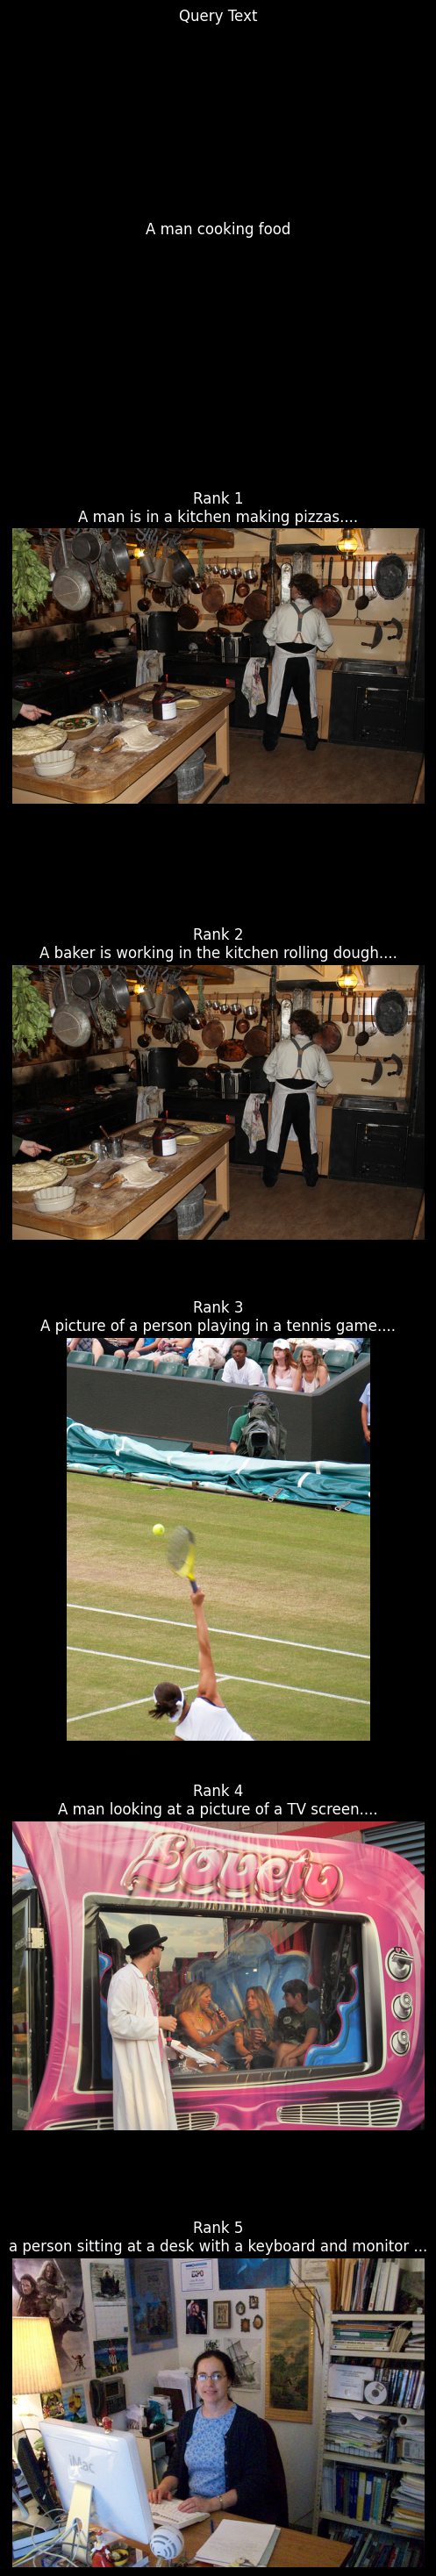

In [31]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# %matplotlib inline setting (for running in Jupyter Notebook)
%matplotlib inline

# ✅ Clear previous plots
plt.close('all')

# ✅ Set the query text
query_text = "A man cooking food"

# ✅ Generate query text embedding
query_embedding = clip_embeddings.embed_query(query_text)

# ✅ Elasticsearch KNN search
query_body = {
    "knn": {
        "field": "vector",
        "query_vector": query_embedding,
        "k": 5
    }
}

results = es.search(index=new_index_name, body=query_body)

# ✅ Visualize search result images
print("🔍 Text-to-Image Search Results:")
fig, axes = plt.subplots(6, 1, figsize=(5, 30))

# Display the query text (text cannot be displayed as an image, so it is shown in the title)
axes[0].text(0.5, 0.5, query_text, fontsize=12, ha='center', va='center', wrap=True)
axes[0].set_title("Query Text")
axes[0].axis("off")

# Display similar images
for i, hit in enumerate(results['hits']['hits']):
    image_path = hit['_source']['metadata']['image_path']
    caption = hit['_source']['text']
    
    try:
        if os.path.exists(image_path):  # Check if the image path exists
            result_image = Image.open(image_path)
            axes[i+1].imshow(result_image)
            axes[i+1].set_title(f"Rank {i+1}\n{caption[:100]}...")
            axes[i+1].axis("off")
        else:
            axes[i+1].axis("off")
            axes[i+1].set_title(f"❌ Image not found\n{image_path}")
    except FileNotFoundError:
        axes[i+1].axis("off")
        axes[i+1].set_title(f"❌ Image not found\n{image_path}")

# Adjust layout and display
plt.tight_layout()
plt.show()

## Image-to-Image Multimodal Search
- Utilizes the `CLIP` model to generate vector embeddings from an input image.
- Performs a similarity search in `Elasticsearch` to find images with matching vector representations.

This approach enables highly accurate image retrieval based on visual content, making it ideal for tasks like finding visually similar images or identifying patterns across datasets. 🚀✨

🔍 Image-to-Image Search Results:


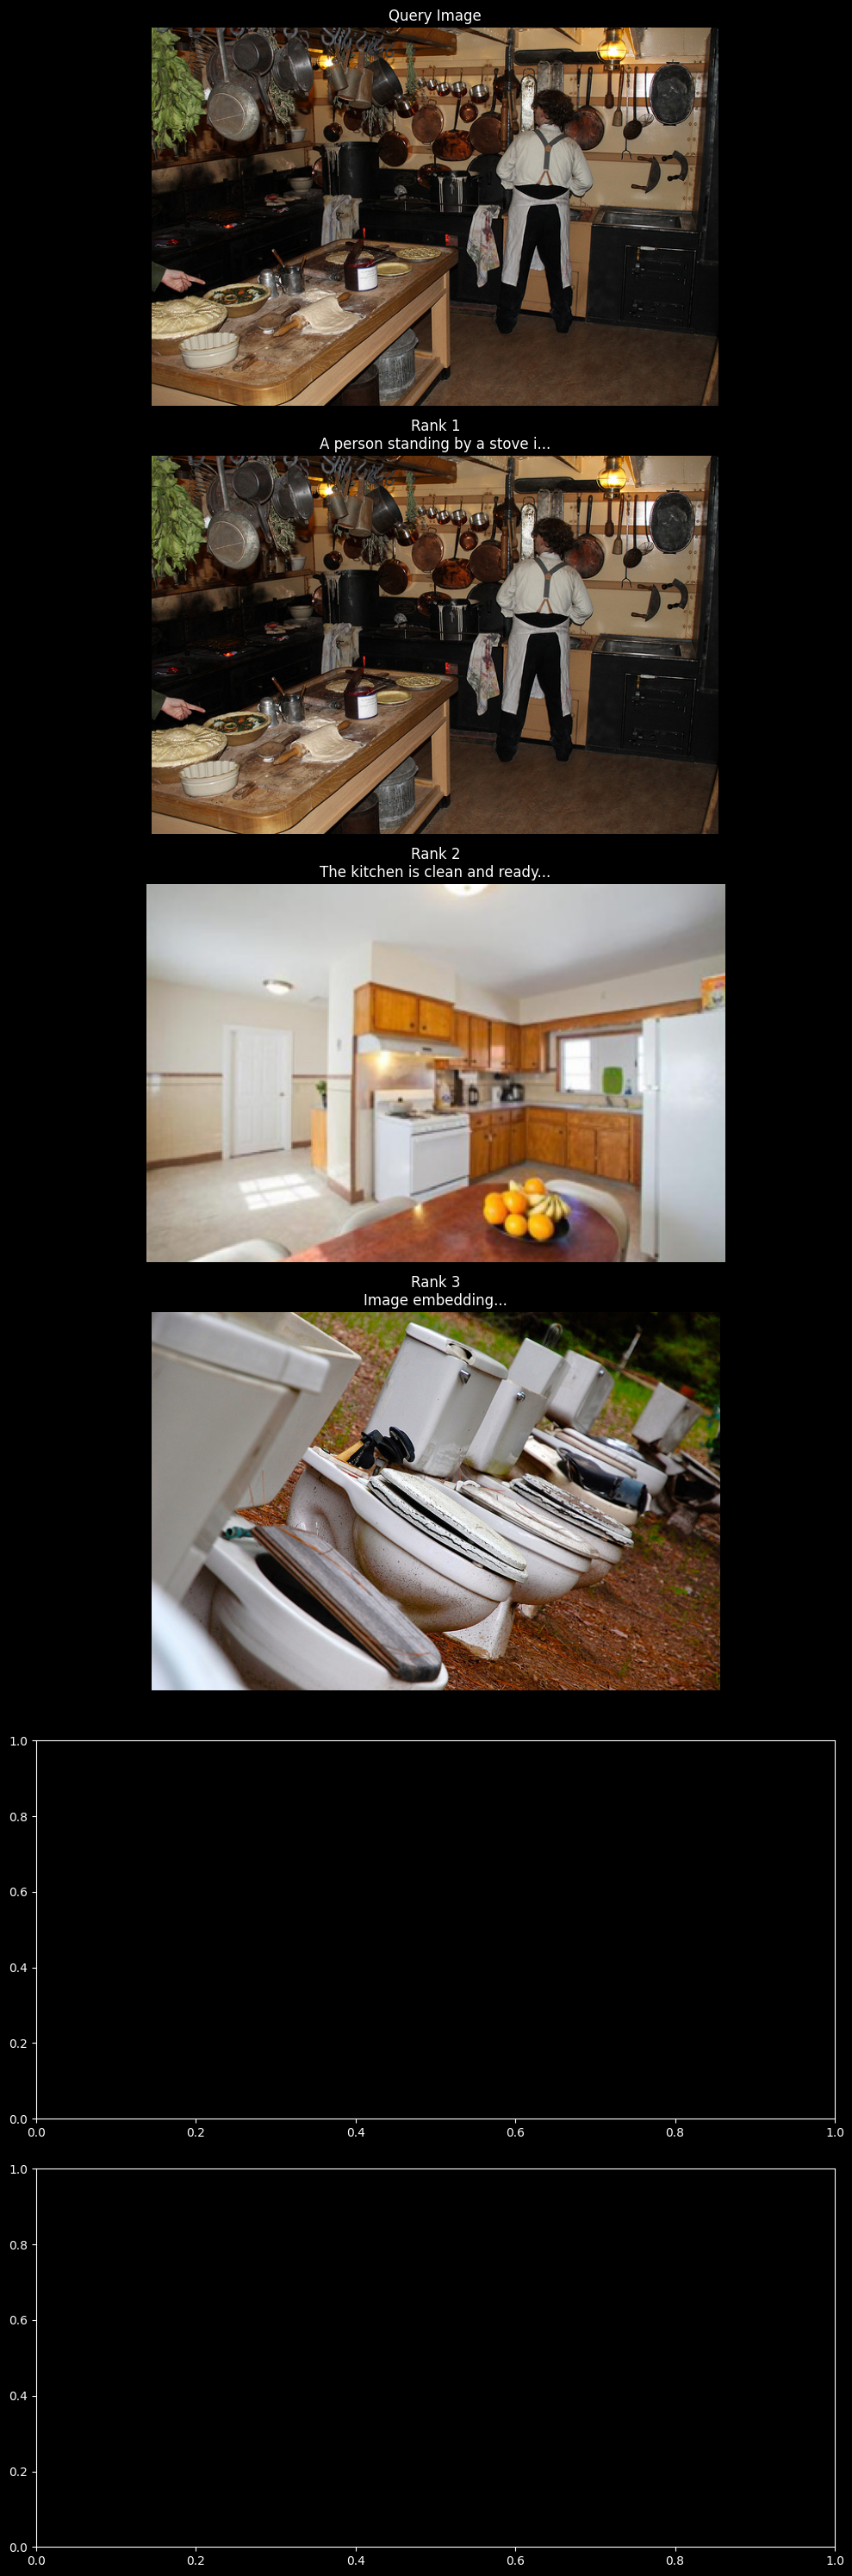

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# %matplotlib inline setting (for running in Jupyter Notebook)
%matplotlib inline

# ✅ Clear previous plots
plt.close('all')

# ✅ Set the query image
query_image_path = os.path.join(IMAGES_DIR, "000000397133.jpg")

# ✅ Generate query image embedding
query_embedding = clip_embeddings.embed_image([query_image_path])[0]  # Pass the path

# ✅ Elasticsearch KNN search
query_body = {
    "knn": {
        "field": "vector",
        "query_vector": query_embedding,
        "k": 5
    },
    "collapse": {
        "field": "metadata.image_path"  # Remove duplicates based on the 'image_path' field
    }
}

results = es.search(index=new_index_name, body=query_body)

# ✅ Visualize search result images (Vertically aligned)
print("🔍 Image-to-Image Search Results:")
fig, axes = plt.subplots(6, 1, figsize=(10, 30))

# Display the query image
axes[0].imshow(Image.open(query_image_path))
axes[0].set_title("Query Image")
axes[0].axis("off")

# Display similar images
for i, hit in enumerate(results['hits']['hits']):
    image_path = hit['_source']['metadata']['image_path']
    caption = hit['_source']['text']
    
    try:
        if os.path.exists(image_path):  # Check if the image path exists
            result_image = Image.open(image_path)
            axes[i+1].imshow(result_image)
            axes[i+1].set_title(f"Rank {i+1}\n{caption[:30]}...")
            axes[i+1].axis("off")
        else:
            axes[i+1].axis("off")
            axes[i+1].set_title(f"❌ Image not found\n{image_path}")
    except FileNotFoundError:
        axes[i+1].axis("off")
        axes[i+1].set_title(f"❌ Image not found\n{image_path}")

# Adjust layout and display
plt.tight_layout()
plt.show()

In [33]:
# Define a query to match all documents
query = {
    "query": {
        "match_all": {}
    }
}

# Execute the delete operation
response = es.delete_by_query(index="es_langchain_tutorial_multimodal", body=query)
print("🗑️ All documents have been successfully deleted!")
print(response)

🗑️ All documents have been successfully deleted!
{'took': 330, 'timed_out': False, 'total': 600, 'deleted': 600, 'batches': 1, 'version_conflicts': 0, 'noops': 0, 'retries': {'bulk': 0, 'search': 0}, 'throttled_millis': 0, 'requests_per_second': -1.0, 'throttled_until_millis': 0, 'failures': []}


In [34]:
delete_idxs = [
    "es_langchain_tutorial",
    "es_langchain_tutorial_multimodal",
]

for index in delete_idxs:
    response = es.indices.delete(index=index, ignore=[400, 404])
    print(response)

{'acknowledged': True}
{'acknowledged': True}
